# Cyberbullying Detection Using Machine Learning

# Introduction

**Problem Statement:**

Cyberbullying merupakan suatu masalah yang sering dihadapi oleh pengguna internet, terutama anak-anak dan remaja. Cyberbullying adalah tindak kekerasan yang dilakukan secara online, melalui media seperti pesan teks, media sosial, atau aplikasi chatting. Tindak kekerasan ini dapat menyebabkan konsekuensi yang serius bagi korban, seperti tekanan emosional, stres, dan bahkan bunuh diri

**Gools:**
- Menggunakan teknik machine learning untuk mengidentifikasi dan mengelola konten cyberbullying secara otomatis.
- Membantu perusahaan atau lembaga yang terkait dalam mengurangi resiko cyberbullying pada pengguna internet.

**Data Information**

Kumpulan data Cyberbullying diperoleh dari Kaggle. Cyberbullying datasets adalah sekumpulan komentar yang telah dikumpulkan dari media sosial instagram untuk penelitian Cyberbullying Detection. Ini berisi satu set komentar dalam bahasa Indonesia sebanyak 650 komentar, yang ditandai sesuai dengan Bullying atau Non-bullying.

# Import Library

In [165]:
import string
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")
sns.set(style='darkgrid')
%matplotlib inline

# Data Preparation

## Load Data

In [166]:
dataset = pd.read_excel('../Dataset/cyberbullying-instagram.xlsx')
dataset.sample(5)

,No.,Nama Instagram,Komentar,Kategori,Tanggal Posting,Nama Akun IG Artis/Selebgram,Unnamed: 6,Unnamed: 7
621,622,@hasana_usna,"""Congrats kak, kamu memang pantes mendapatkannya""",Non-bullying,04 April 2021,@isyanasarasvati,NaN,NaN
74,75,@maryamcici29,"""Mbak mell sehat dan sukses ya""",Non-bullying,31 Desember 2020,@rosameldianti_,NaN,NaN
248,249,@alyafdhlh_,"""Kak jessica yg nungguin+setia sm kk loh pas a...",Non-bullying,20 Maret 2020,@eeericko,NaN,NaN
511,512,@weirdlifes_,"""Sutan kamu sangat lucu dan menggemaskan""",Non-bullying,27 Februari 2021,@jeromepolin,NaN,NaN
318,319,@robilmlna,"""NARKOBOYY NGELUARIN LIDAHH, AJG MAU APA, MAU ...",Bullying,28 Maret 2020,@eeericko,NaN,NaN


## Data Cleaning

In [167]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   No.                            650 non-null    int64  
 1   Nama Instagram                 650 non-null    object 
 2   Komentar                       650 non-null    object 
 3   Kategori                       650 non-null    object 
 4   Tanggal Posting                650 non-null    object 
 5   Nama Akun IG  Artis/Selebgram  650 non-null    object 
 6   Unnamed: 6                     0 non-null      float64
 7   Unnamed: 7                     0 non-null      float64
dtypes: float64(2), int64(1), object(5)
memory usage: 40.8+ KB


In [169]:
dataset.drop([
    'No.',
    'Nama Instagram',
    'Tanggal Posting',
    'Nama Akun IG  Artis/Selebgram',
    'Unnamed: 6',
    'Unnamed: 7'
    ], axis=1, inplace=True)

In [170]:
dataset.duplicated().sum()

0

In [171]:
dataset.rename(columns={"Komentar" : "komentar","Kategori" : "kategori"}, inplace=True)

## Text Pre-Processing

In [172]:
kamus_singkatan = pd.read_csv('../Dataset/kamus_singkatan.csv', usecols=['singkatan','asli'])
stopwords = pd.read_csv('../Dataset/stopwordsID.csv', names=['stopwords'])

In [173]:
dataset['komentar_lowercase'] = dataset['komentar'].apply(lambda text: text.lower())

In [174]:
def text_clean(text):
    text = re.sub(r'\n|\t', ' ', text)
    # remove all text that contains the url
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # removes all HTML tags contained in the text
    text = re.sub(r'<.*?>+', '', text)
    # Delete usernames that contain the "@" sign 
    text = re.sub(r'@\w+', '', text)
    # remove the words wk, wkwk, etc.
    text = re.sub(r'\b[wk]*(?:wk|kw)[wk]*\b', '', text)
    # remove punctuation
    text = text.translate(str.maketrans('','', string.punctuation))
    # remove number
    text = re.sub(r'\d', '', text)
    # remove non-letter characters with empty strings
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # remove more than one space
    text = re.sub(r'\s{2,}', ' ', text)
    # remove spaces at the beginning and end of sentences
    text = re.sub(r'^\s+|\s+$', '', text)
    return text

In [175]:
dataset['komentar_clean'] = dataset['komentar_lowercase'].apply(text_clean)

for i, row in dataset.sample(5).iterrows():
    print(f"Index: {i}")
    print(f"Before: {row['komentar_lowercase']}")
    print(f"After: {row['komentar_clean']}")
    print()

Index: 544
Before: "dilihat sekilas pun tampak jelas kalau cantikkan syifa"
After: dilihat sekilas pun tampak jelas kalau cantikkan syifa

Index: 134
Before: "kereennnn.. dari bully.an netizen menjadikanmu mau belajar"
After: kereennnn dari bullyan netizen menjadikanmu mau belajar

Index: 473
Before: "kasian yah sdh stress banyak masalah"
After: kasian yah sdh stress banyak masalah

Index: 557
Before: "kasihan ya , nagita punya suami kerjaannya berzinah terus"
After: kasihan ya nagita punya suami kerjaannya berzinah terus

Index: 194
Before: "eh bocah mending lo mati aja gak guna juga ada orang kayak lo hahahahaha"
After: eh bocah mending lo mati aja gak guna juga ada orang kayak lo hahahahaha



In [176]:
def replace_abbreviation(text):
    words = text.split()
    expanded_text = []
    for word in words:
        abbreviation_row = kamus_singkatan[kamus_singkatan["singkatan"] == word.lower()]
        if not abbreviation_row.empty:
            expanded_text.append(abbreviation_row["asli"].iloc[0])
        else:
            expanded_text.append(word)
    return " ".join(expanded_text)

In [177]:
dataset["komentar_norm"] = dataset['komentar_clean'].apply(lambda text: replace_abbreviation(text))

for i, row in dataset.sample(5).iterrows():
    print(f"Index: {i}")
    print(f"Before: {row['komentar_clean']}")
    print(f"After: {row['komentar_norm']}")
    print()

Index: 607
Before: raisa pake baju merah sumpahh cantik bgttt
After: raisa pakai baju merah sumpahh cantik bgttt

Index: 434
Before: buat kalian para pens lonte jgn tkut listi miskin krna dipecat krna dia bsa kaya lgi dgn cara ya nglonte
After: buat kalian para pens lonte jangan takut listi miskin karena dipecat karena dia bisa kaya lagi dengan cara ya nglonte

Index: 318
Before: narkoboyy ngeluarin lidahh ajg mau apa mau tes urin
After: narkoboyy ngeluarin lidahh ajg mau apa mau tes urin

Index: 276
Before: astaga ngehujat sampe postingan paling bawah
After: astaga ngehujat sampai postingan paling bawah

Index: 546
Before: dahlahh emang cantik luar dalam kmu ini cippp
After: dahlahh memang cantik luar dalam kamu ini cippp



In [178]:
stopwords = set(stopwords['stopwords'].to_list())

def stopwords_removal(text):
    # tokenize
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    tokenizer = tokenizer.tokenize(text)
    # stopword removal
    stopwords_rmv = [s for s in tokenizer if s not in stopwords]
    stopwords_rmv = ' '.join(stopwords_rmv)
    return stopwords_rmv

In [179]:
dataset['stopword_rmv'] = dataset['komentar_norm'].apply(stopwords_removal)

for i, row in dataset.sample(5).iterrows():
    print(f"Index: {i}")
    print(f"Before: {row['komentar_norm']}")
    print(f"After: {row['stopword_rmv']}")
    print()

Index: 397
Before: ini bukan era kamu lagi sekarang kamu penuh dengan cacimaki telen ludah sendiri
After: era penuh cacimaki telen ludah

Index: 102
Before: dia memutuskan menjadi tumbal apartemen
After: memutuskan tumbal apartemen

Index: 44
Before: cantik sekali kalau meldi muka natural kek gini
After: cantik meldi muka natural kek gini

Index: 519
Before: bang saya nonton kamu setelah saya kerja di jepang bermanfaat sangat kontennya jadi gampang kalau mau cari apa apa di jepang
After: bang nonton kerja jepang bermanfaat kontennya gampang cari jepang

Index: 526
Before: baru x ini baca caption harus mikir dan pakai kalkulator cuyyy hahaha
After: x baca caption mikir pakai kalkulator cuyyy hahaha



# Exploratory Data Analysis

In [182]:
dataset[['stopword_rmv','kategori']].groupby('kategori').describe()

stopword_rmv                                          
                    count unique                           top freq
kategori                                                           
Bullying              325    324  jelek tukang selingkuh buriq    2
Non-bullying          325    325     kaka tidur yaa pagi capai    1

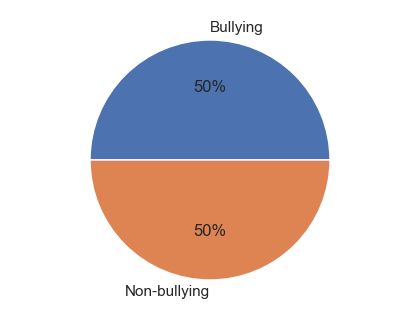

In [183]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
labels = dataset['kategori'].sort_values().unique().tolist()
dataset_val_count = dataset['kategori'].value_counts()
ax.pie(dataset_val_count, labels=labels, autopct='%.0f%%')
plt.show()

In [184]:
dataset['length'] = dataset['stopword_rmv'].apply(lambda x: len(x.split()) * 1)
dataset[['stopword_rmv','length']].head()

,stopword_rmv,length
0,kaka tidur yaa pagi capai,5
1,makan nasi padang badannya,4
2,suka cukur jembut manggung,4
3,hai kak isyana ngefans kak isyanaaku suka lagu...,13
4,manusia bidadari sih herann deh cantik,6


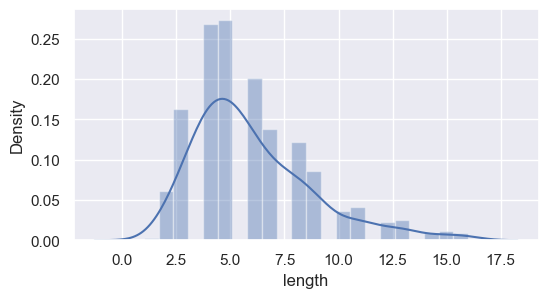

In [185]:
plt.figure(figsize=(6,3))
sns.distplot(dataset.length)
plt.show()

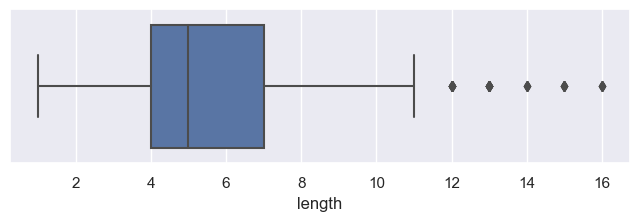

In [186]:
plt.figure(figsize=(8,2))
sns.boxplot(x=dataset['length'])
plt.show()

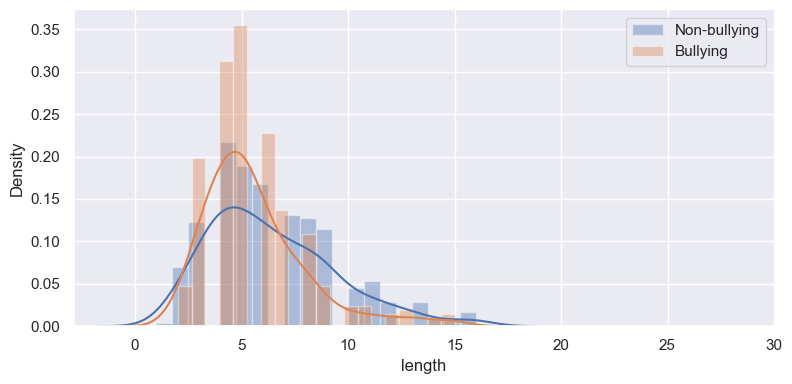

In [187]:
g = sns.FacetGrid(data=dataset, hue="kategori", height=4, aspect=2)
g.map(sns.distplot, 'length', bins=20)
g.set(xticks=np.arange(0,35,5))
plt.legend()
plt.show()

In [188]:
def word_cloud_vis(dataset):
    wordcloud = WordCloud().generate(' '.join(dataset))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

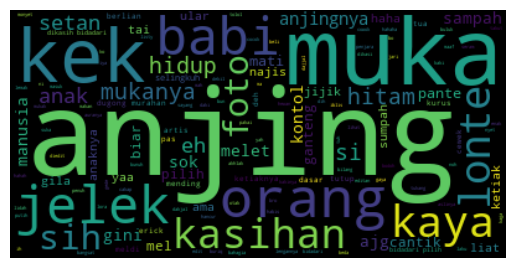

In [189]:
bully = dataset[dataset['kategori'] == 'Bullying']['stopword_rmv']
word_cloud_vis(bully)

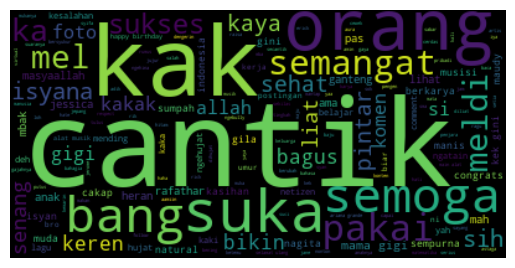

In [190]:
not_bully = dataset[dataset['kategori'] == 'Non-bullying']['stopword_rmv']
word_cloud_vis(not_bully)

In [191]:
def word_count_vis(dataset, top=5):
    word_counts = dataset.str.split(expand=True).stack().value_counts()

    sns.barplot(x=word_counts[:top].values, y=word_counts[:top].index, orient='h')
    plt.xlabel('Kata')
    plt.ylabel('Frekuensi kemunculan')
    plt.show()

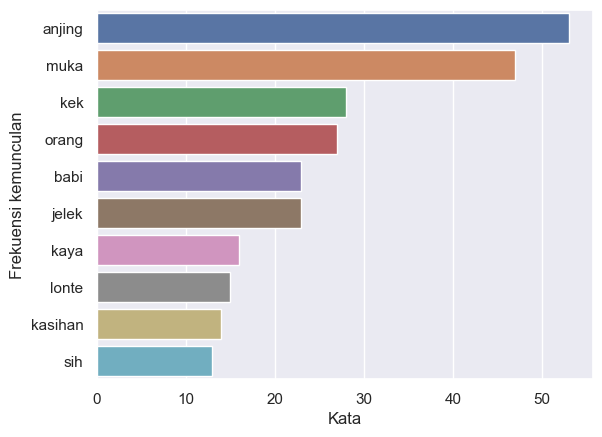

In [192]:
word_count_vis(bully, 10)

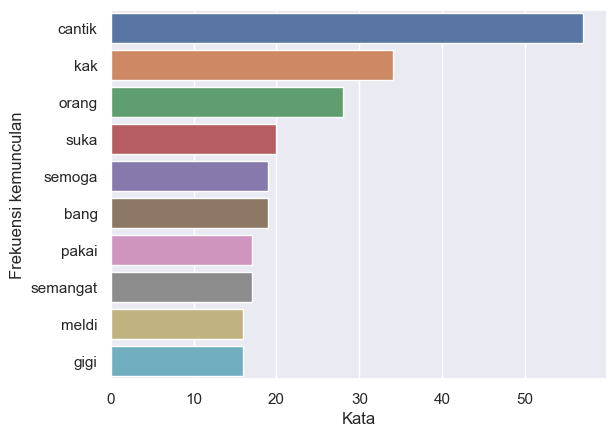

In [193]:
word_count_vis(not_bully, 10)

# Data Preparation Modeling

## Label Encoding

In [194]:
lb = LabelBinarizer()
lb.fit(dataset['kategori'])
dataset['kategori'] = lb.transform(dataset['kategori'])

## Splitting Dataset Training and Testing

In [195]:
from sklearn.model_selection import train_test_split

X = dataset['stopword_rmv']
y = dataset['kategori']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

## Term Frequency–Inverse Document Frequency (TF-IDF)
TF-IDF measures the importance of a word by calculating two factors:

- Term Frequency (TF): The number of occurrences of a word in a document. The more often the word appears in the document, the higher its importance.
- Inverse Document Frequency (IDF): The number of documents containing a word compared to the total number of documents. The fewer documents that contain a word, the higher its importance.

In [196]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train.values)
train_vec = vectorizer.transform(X_train.values)
test_vec = vectorizer.transform(X_test.values)

# Modoling

In [197]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [198]:
def evaluate_model(model, X, y):
    pred = model.predict(X)
    print('Model Performance')
    print('Accuracy Score = {:0.2f}'.format(accuracy_score(y, pred)))
    print('Precission Score = {:0.2f}'.format(precision_score(y, pred)))
    print('Recal Score = {:0.2f}'.format(recall_score(y, pred)))

## Base Model

In [199]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(train_vec, y_train)

print(multinomial_nb.score(train_vec, y_train), multinomial_nb.score(test_vec, y_test))
print("=========================================")
evaluate_model(multinomial_nb, test_vec, y_test)

0.9903846153846154 0.8461538461538461
Model Performance
Accuracy Score = 0.85
Precission Score = 0.92
Recal Score = 0.78


In [200]:
svc = SVC()
svc.fit(train_vec, y_train)

print(svc.score(train_vec, y_train), svc.score(test_vec, y_test))
print("=========================================")
evaluate_model(svc, test_vec, y_test)

1.0 0.8538461538461538
Model Performance
Accuracy Score = 0.85
Precission Score = 0.92
Recal Score = 0.80


In [201]:
mlp = MLPClassifier()
mlp.fit(train_vec, y_train)

print(mlp.score(train_vec, y_train), mlp.score(test_vec, y_test))
print("=========================================")
evaluate_model(mlp, test_vec, y_test)

1.0 0.8153846153846154
Model Performance
Accuracy Score = 0.82
Precission Score = 0.91
Recal Score = 0.72


## Hyperparameter Tuning

# Conclusion